Plan:
- Data analysis:
    - Data visualization and exploration(means, medians etc.), analyse distributions 
    - Dealing with NaN values
- Feature Engineering (Feature selection):
    - Visualize correlation matrix in order to find least useful features that do not corelate with the output 
    - Perform a dimesion reduction:
        - Make a PCA plot
        - Try Heatmap, t-SNE plot, Multi-Dimensional Scaling(MDS)
- Data preparation:
    - Label encoding for categorical variables
    - Data normalization
    - Data splitting
- Selecting ML algorithm
- Regularization
- Hyperparameter tuning and use of cross-validation
- Testing

Notes:
<br>After looking at the data I have come to conclusion that the amount of features is big, so I decided to perform feature selection at first and then do some Feature engineering. Also the categorical variables seems not encoded and there are way too many categories in some features. There are also a lot of NaN values and I need to pick one of the methods to replace them.

## 0. Install dependencies

In [13]:
import pandas as pd
import csv
import matplotlib.pyplot as plt 
import seaborn as sn
import numpy as np

from sklearn.feature_selection import mutual_info_regression
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer



## 1. Load data

In [14]:
df = pd.read_csv("./train_df.csv", sep='\t')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26824 entries, 0 to 26823
Columns: 554 entries, Unnamed: 0 to gb
dtypes: float64(416), int64(138)
memory usage: 113.4 MB
None
   Unnamed: 0   num_1   num_2  num_3   num_4   num_5   num_6  num_7  cat_1  \
0           0  1377.3  3712.9    NaN  1303.0  2409.0  1281.7   43.0      1   
1           1    20.0    13.4    NaN   565.0     NaN   357.2   19.0      1   
2           4   150.6     1.8    NaN  2294.0    15.0   107.6   76.0      1   
3           5    11.4   178.0    NaN  1236.0     NaN   350.6   41.0      1   
4           6  5372.0  3386.0    NaN  1340.0     NaN    14.0   45.0      1   

   num_8  ...  num_413  cat_132  cat_133      num_414  num_415  num_416  \
0  195.0  ...  11327.5        1        1  28162496.65      0.0     0.07   
1  170.0  ...    168.6        1        1    989383.82      0.0     0.56   
2  196.0  ...    209.1        1        1     87444.51      0.0     0.01   
3  117.0  ...     56.9        1        1    297608.00  

In [15]:
repetitive_id = df['id'].duplicated()
print(len(df[repetitive_id==True]))

21581


In [16]:
print(df.loc[df["id"]==4320]) # take as an example id number 4320 and analyse if all the variables are the same

       Unnamed: 0  num_1  num_2  num_3   num_4  num_5  num_6  num_7  cat_1  \
17121       37793    4.2   97.2    NaN  2090.0  130.5  409.3   70.0      1   
19880       44433    4.2   97.2    NaN  2121.0  130.5  409.3   71.0      1   
26820       61105    4.2   97.2    NaN  2149.0  130.5  409.3   72.0      1   

       num_8  ...  num_413  cat_132  cat_133     num_414  num_415  num_416  \
17121   98.0  ...    596.7        1        1  1089878.89      0.0     0.11   
19880  129.0  ...    596.7        1        1   782974.94      0.0     0.17   
26820  157.0  ...    596.7        1        1   557554.94      0.0     0.26   

       cat_134  cat_135    id  gb  
17121        5        1  4320   0  
19880        5        1  4320   0  
26820        5        1  4320   0  

[3 rows x 554 columns]


As we can see the id may be repetitive and it means that one person may be present in dataframe various times. However, the data of the columns is not always the same and some of the features may change.
<br>The id value may not be as important as the amout of its occurance in dataframe for the future model so we can create a new column that indicates how many times id was seen in the dataframe before.
<br>We won't use id column as the training data as well as the result (gb), so I will move these values to another dataframes

In [17]:
data = df.drop(['gb','id'],axis=1)
labels = df['gb']
ids = df['id']

In [18]:
data['num_cust_1'] = df.groupby('id').cumcount() + 1 # create new custom column (feature engineering)

In [19]:
print("New feature column:")
print(data['num_cust_1'])

New feature column:
0        1
1        1
2        1
3        1
4        1
        ..
26819    1
26820    3
26821    8
26822    2
26823    1
Name: num_cust_1, Length: 26824, dtype: int64


In [20]:
print("Balance of target value:")
print(str(len(labels)) + " rows = 100%")
for value in labels.unique():
    print("Number of " + str(value) +":")
    print(str(labels[labels==value].count()) +" rows = " + str((labels[labels==value].count()*100/len(labels))) +"%")


Balance of target value:
26824 rows = 100%
Number of 0:
26231 rows = 97.78929317029525%
Number of 1:
593 rows = 2.210706829704742%


The output value (target value) is very impalanced. There are several techniques to deal with this, I am going to use Synthetic Minority Oversampling Technique (SMOTE), change the weights on the loss function(or penalized learning), change the Performance Metric (use confusion matrix, area Under ROC Curve)
<br>
<br>[info](https://medium.com/metaor-artificial-intelligence/solving-the-class-imbalance-problem-58cb926b5a0f#:~:text=Imbalanced%20classification%20is%20a%20common,bias%20in%20the%20trained%20model.)
<br>[more usefull info](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

In order to use SMOTE, we need to find a way to deal with NaN values. The main problem is that I don't know the origin of these features nor their names, so I would use KNNImputer.

First of all lets drop all the columns that have >80% NaN values and correlate < 0.08 So we can focus on important columns with enough data to work with

In [21]:
nan_columns = []
for column in df.columns:
    if (df[column].isna().sum())*100/len(df[column]) >=80:
        nan_columns.append(column)

In [22]:
for column in nan_columns:
    print("There are " + str(df[column].notna().sum()) + f" not NaN values in column {column} and amount of '1' under this condition is " + str(sum(df[df[column].notna()]["gb"]))+ ", correlation: "+str(abs(df.loc[df[column].notna(), [column, 'gb']].corr().iloc[0, 1])))

There are 63 not NaN values in column num_3 and amount of '1' under this condition is 0, correlation: nan
There are 36 not NaN values in column num_11 and amount of '1' under this condition is 0, correlation: nan
There are 535 not NaN values in column num_18 and amount of '1' under this condition is 0, correlation: nan
There are 445 not NaN values in column num_20 and amount of '1' under this condition is 0, correlation: nan
There are 62 not NaN values in column num_21 and amount of '1' under this condition is 0, correlation: nan
There are 1 not NaN values in column num_22 and amount of '1' under this condition is 0, correlation: nan
There are 0 not NaN values in column num_23 and amount of '1' under this condition is 0, correlation: nan
There are 1 not NaN values in column num_24 and amount of '1' under this condition is 0, correlation: nan
There are 799 not NaN values in column num_25 and amount of '1' under this condition is 78, correlation: 0.025660684954407487
There are 2459 not N

In [23]:
for column in nan_columns:
    if column in data.columns:
        if abs(df.loc[df[column].notna(), [column, 'gb']].corr().iloc[0, 1])<0.08:
            print(column + " dropped")
            data = data.drop(column, axis=1)

num_25 dropped
num_35 dropped
num_36 dropped
num_37 dropped
num_39 dropped
num_46 dropped
num_47 dropped
num_56 dropped
num_61 dropped
num_63 dropped
num_65 dropped
num_78 dropped
num_82 dropped
num_89 dropped
num_93 dropped
num_96 dropped
num_100 dropped
num_109 dropped
num_116 dropped
num_118 dropped
num_126 dropped
num_127 dropped
num_146 dropped
num_163 dropped
num_182 dropped
num_199 dropped
num_208 dropped
num_224 dropped
num_236 dropped
num_241 dropped
num_245 dropped
num_247 dropped
num_249 dropped
num_251 dropped
num_273 dropped
num_278 dropped
num_280 dropped
num_286 dropped
num_291 dropped
num_295 dropped
num_297 dropped
num_302 dropped
num_316 dropped
num_326 dropped
num_333 dropped
num_337 dropped
num_343 dropped
num_368 dropped
num_374 dropped
num_377 dropped
num_388 dropped
num_394 dropped
num_399 dropped
num_403 dropped


In [12]:
print(len(data.columns))

499


Skipping features without any observed values

In [24]:
rows = len(data)
for column in data.columns:
    if sum(data[column].isna())==rows:
        data = data.drop(column, axis=1)

In [25]:
impute_knn = KNNImputer(n_neighbors=2)
data_imputed = impute_knn.fit_transform(data)

In [26]:
dataframe_updated = pd.DataFrame(data_imputed, columns=data.columns)

In [27]:
for column in dataframe_updated.columns:
    if column.find("cat")!=-1:
        dataframe_updated[column] = dataframe_updated[column].astype(int)


In [28]:
dataframe_updated.to_csv('updated_df.csv',index=False)

Dealing with class imbalance

In [29]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(dataframe_updated, labels)


c:\Users\Tymof\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Tymof\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [31]:
print("Balance of target value:")
print(str(len(x_smote)) + " rows = 100%")
for value in y_smote.unique():
    print("Number of " + str(value) +":")
    print(str(y_smote[y_smote==value].count()) +" rows = " + str((y_smote[y_smote==value].count()*100/len(y_smote))) +"%")


Balance of target value:
52462 rows = 100%
Number of 0:
26231 rows = 50.0%
Number of 1:
26231 rows = 50.0%


## 2. Analyze Data

The amount of features is still big enough. Lets drop all the columns that have correlation with target value < 0.03 using correlation matrix

In [33]:

full_df = pd.concat([x_smote, y_smote], axis=1)


In [34]:
print(full_df)

         Unnamed: 0   num_1   num_2        num_3        num_4        num_5  \
0          0.000000  1377.3  3712.9  3563.000000  1303.000000  2409.000000   
1          1.000000    20.0    13.4    76.000000   565.000000    30.000000   
2          4.000000   150.6     1.8    76.000000  2294.000000    15.000000   
3          5.000000    11.4   178.0    76.000000  1236.000000    54.700000   
4          6.000000  5372.0  3386.0   265.000000  1340.000000   181.800000   
...             ...     ...     ...          ...          ...          ...   
52457  34546.285457    82.3    26.9    76.000000   891.863308   121.700000   
52458  23357.716802   668.5    64.7    63.108096  1348.273179   203.668341   
52459  29999.349167    52.1    22.1  3488.800000   447.767140  1180.000000   
52460  50780.311051    12.5     5.5    76.000000  2019.441154    60.550000   
52461  15289.681749   366.4   118.1    41.921277   871.902611   578.300000   

        num_6      num_7  cat_1       num_8  ...  num_413  cat_

In [35]:
corr_matrix = full_df.corr()
# sn.heatmap(corr_matrix, annot=True) # hard to read due to big amount of columns
# plt.show()


In [36]:
print(len(full_df.loc[:,abs(corr_matrix.loc["gb"])>0.03].columns))
print(full_df.loc[:,abs(corr_matrix.loc["gb"])>0.03])

314
         Unnamed: 0   num_1   num_2        num_3        num_4   num_6  \
0          0.000000  1377.3  3712.9  3563.000000  1303.000000  1281.7   
1          1.000000    20.0    13.4    76.000000   565.000000   357.2   
2          4.000000   150.6     1.8    76.000000  2294.000000   107.6   
3          5.000000    11.4   178.0    76.000000  1236.000000   350.6   
4          6.000000  5372.0  3386.0   265.000000  1340.000000    14.0   
...             ...     ...     ...          ...          ...     ...   
52457  34546.285457    82.3    26.9    76.000000   891.863308   306.7   
52458  23357.716802   668.5    64.7    63.108096  1348.273179  1017.6   
52459  29999.349167    52.1    22.1  3488.800000   447.767140  4876.3   
52460  50780.311051    12.5     5.5    76.000000  2019.441154   424.7   
52461  15289.681749   366.4   118.1    41.921277   871.902611   981.9   

           num_7  num_11     num_12       num_13  ...  num_411  num_412  \
0      43.000000    70.0  417.10000  2210.00

That seems better! Lets use Dimensionality Reduction, Feature selection and Regularization

### 2.1 Data Exploration

First let's analyze categorical features. Maybe we would find a way to encode them or find hidden patterns.
<br>
<br>Extracting categorical features:

In [49]:
categorical = []
for column in full_df.columns:
    if column.find("cat")!=-1:
        categorical.append(column)
    df_categorical = full_df[categorical]
        

Descriptive Statistics

Max variance: 88425.10131465446
Min variance: 9.529981251983278e-05
Max max-value: 1461
Min max-value: 2
Max min-value: 1
Min min-value: 1
Max mean: 351.2796500324044
Min mean: 1.0000953070794099
Max median: 276.0
Min median: 1.0


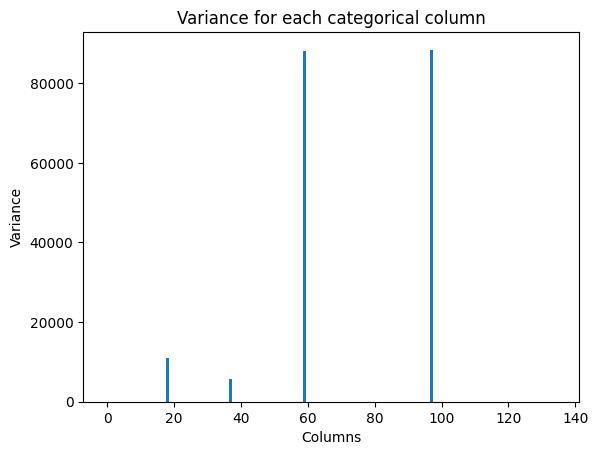

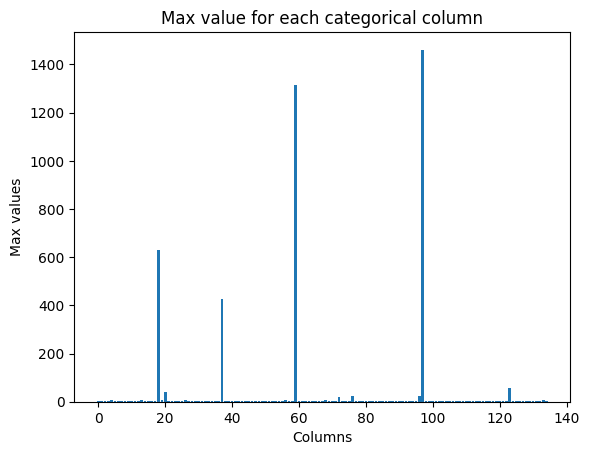

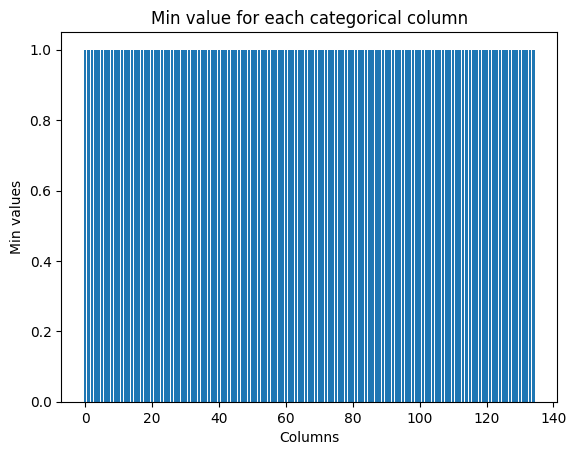

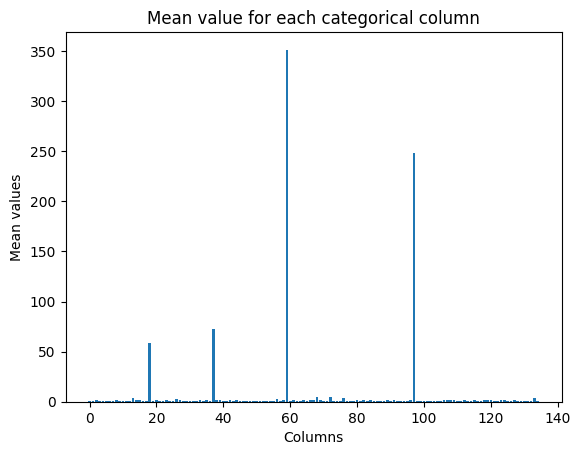

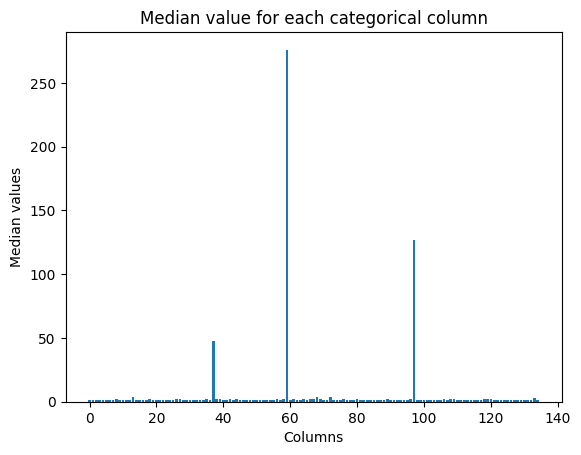

In [50]:
plt.figure(1)
 
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.var())
plt.xlabel("Columns")
plt.ylabel("Variance")
plt.title("Variance for each categorical column")
print("Max variance: " + str(max(df_categorical.var())))
print("Min variance: " + str(min(df_categorical.var())))

plt.figure(2)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.max())
plt.xlabel("Columns")
plt.ylabel("Max values")
plt.title("Max value for each categorical column")
print("Max max-value: " + str(max(df_categorical.max())))
print("Min max-value: " + str(min(df_categorical.max())))

plt.figure(3)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.min())
plt.xlabel("Columns")
plt.ylabel("Min values")
plt.title("Min value for each categorical column")
print("Max min-value: " + str(max(df_categorical.min())))
print("Min min-value: " + str(min(df_categorical.min())))

plt.figure(4)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.mean())
plt.xlabel("Columns")
plt.ylabel("Mean values")
plt.title("Mean value for each categorical column")
print("Max mean: " + str(max(df_categorical.mean())))
print("Min mean: " + str(min(df_categorical.mean())))

plt.figure(5)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.median())
plt.xlabel("Columns")
plt.ylabel("Median values")
plt.title("Median value for each categorical column")
print("Max median: " + str(max(df_categorical.median())))
print("Min median: " + str(min(df_categorical.median())))

plt.show()


Some of the categorical features have way too more classes, on the other hand, most of the features has maximum 10 different classes and the most popular are the first ones (median of all median proves this)

In [51]:
print(df_categorical.median().median())

1.0


As we can see, the median of all medians is 1. <br>
Most of the categorical values equal to 1, avarage, median is near 1 and variance is around 0.<br>
Let's analyse the distribution for some of the features

Lets display distribution of features with high variance and max values

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

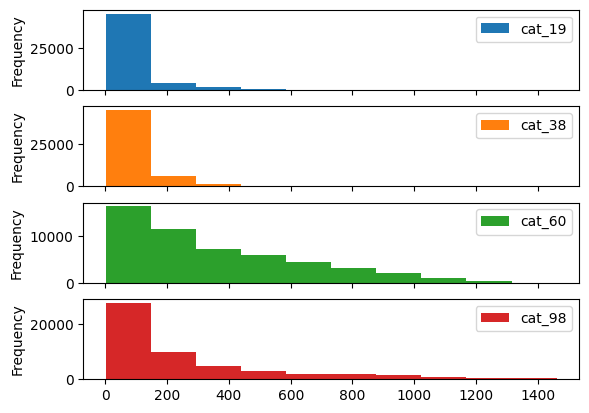

In [52]:
df_categorical.loc[:,df_categorical.var()>100].plot(kind='hist',subplots=True)

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

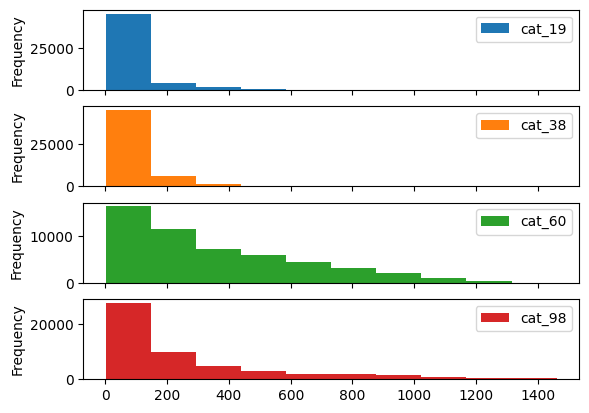

In [53]:
df_categorical.loc[:,df_categorical.max()>100].plot(kind='hist',subplots=True)

Now display distribution of features with low variance and max values

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

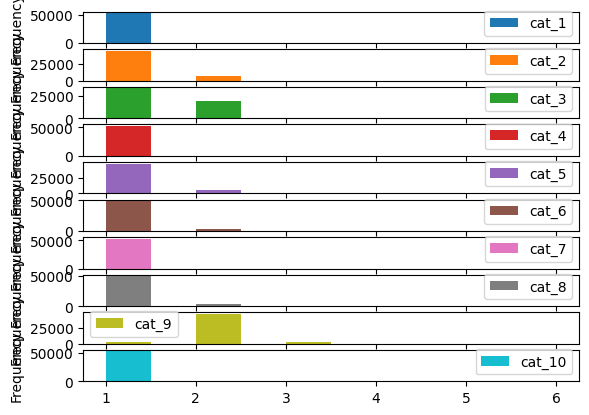

In [54]:
df_categorical.loc[:,df_categorical.var()<10].iloc[:, :10].plot(kind='hist',subplots=True)

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

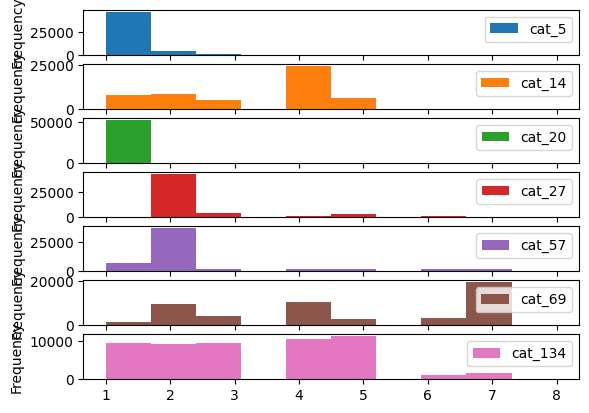

In [55]:
df_categorical.loc[:,(df_categorical.max() > 5) & (df_categorical.max() < 10)].iloc[:, :20].plot(kind='hist',subplots=True)

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

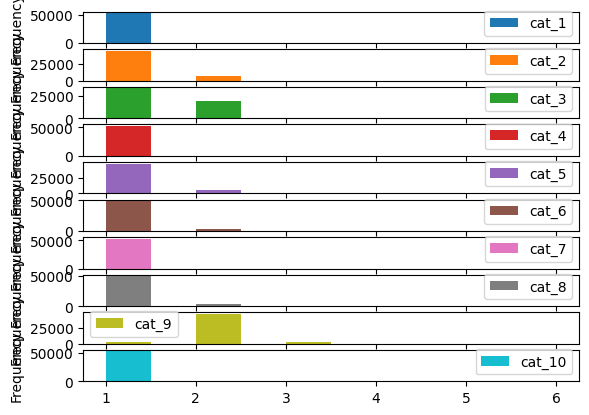

In [56]:
df_categorical.loc[:,df_categorical.max() < 15].iloc[:, :10].plot(kind='hist',subplots=True)

Future: do the same thing for numberic data and make conclusions for the NaN replacement. Goal: do at least correlation matrix.

In [57]:
numerical = []
for column in full_df.columns:
    if column.find("cat")==-1:
        numerical.append(column)
    df_numerical = full_df[numerical]
        

Max variance: 1.1991013504906063e+23
Min variance: 0.0
Max max-value: 35664478500000.0
Min max-value: -8561.0
Max min-value: 15514.0
Min min-value: -1578869000000.0
Max mean: 18047250888.851055
Min mean: -12569254.924537422
Max median: 3459171.3094583084
Min median: -543389.96


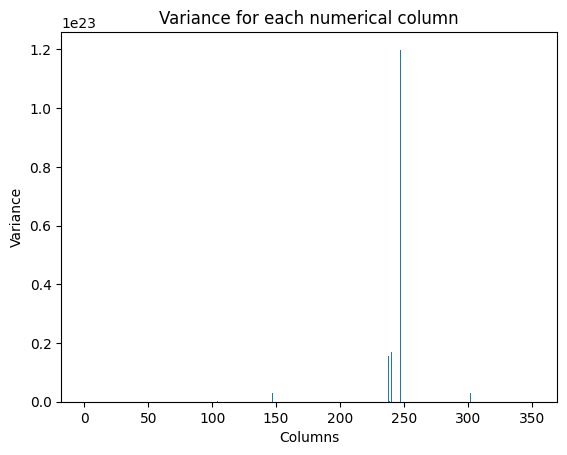

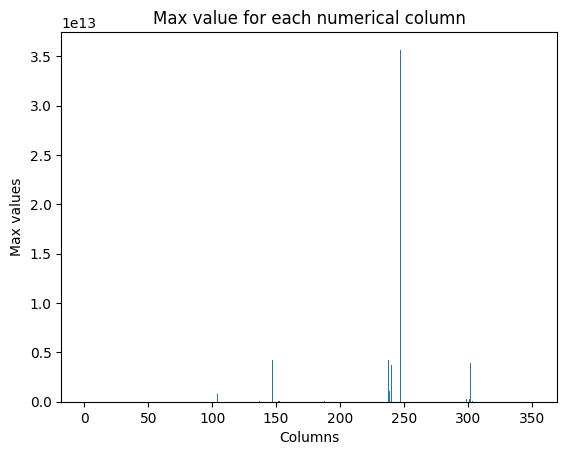

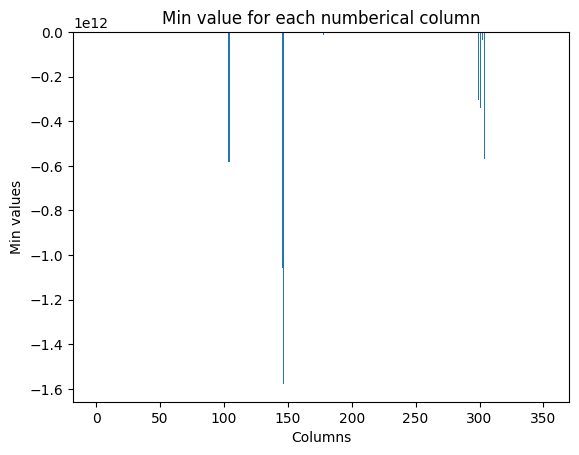

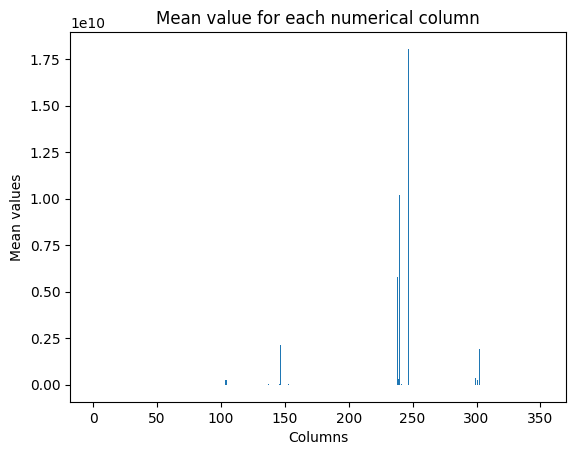

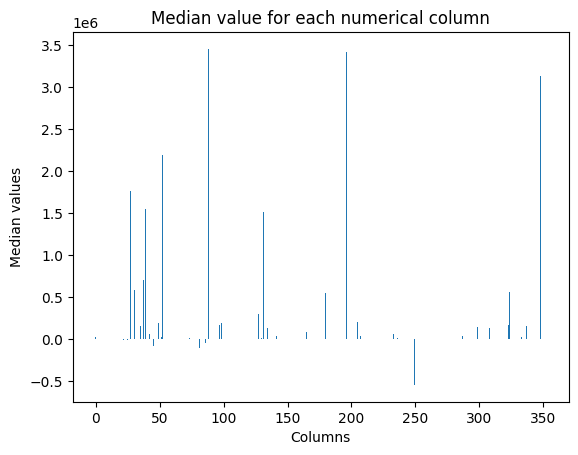

In [58]:
plt.figure(1)
 
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.var())
plt.xlabel("Columns")
plt.ylabel("Variance")
plt.title("Variance for each numerical column")
print("Max variance: " + str(max(df_numerical.var())))
print("Min variance: " + str(min(df_numerical.var())))

plt.figure(2)
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.max())
plt.xlabel("Columns")
plt.ylabel("Max values")
plt.title("Max value for each numerical column")
print("Max max-value: " + str(max(df_numerical.max())))
print("Min max-value: " + str(min(df_numerical.max())))

plt.figure(3)
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.min())
plt.xlabel("Columns")
plt.ylabel("Min values")
plt.title("Min value for each numberical column")
print("Max min-value: " + str(max(df_numerical.min())))
print("Min min-value: " + str(min(df_numerical.min())))

plt.figure(4)
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.mean())
plt.xlabel("Columns")
plt.ylabel("Mean values")
plt.title("Mean value for each numerical column")
print("Max mean: " + str(max(df_numerical.mean())))
print("Min mean: " + str(min(df_numerical.mean())))

plt.figure(5)
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.median())
plt.xlabel("Columns")
plt.ylabel("Median values")
plt.title("Median value for each numerical column")
print("Max median: " + str(max(df_numerical.median())))
print("Min median: " + str(min(df_numerical.median())))

plt.show()


In [59]:
print(df_numerical.median().median())

50.0


array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

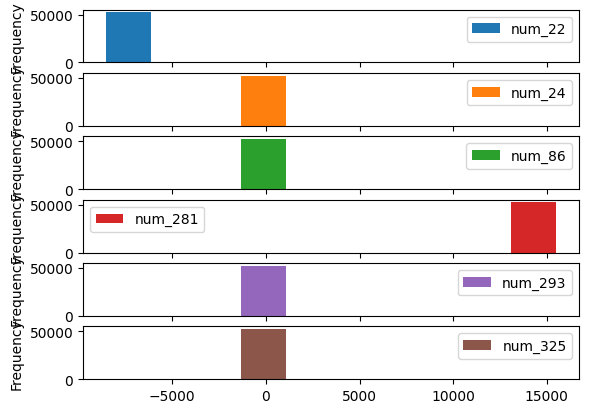

In [60]:
df_numerical.loc[:,df_numerical.var()==0].iloc[:, :10].plot(kind='hist',subplots=True)

Firstly, I have analysed the distributions and then decided how should I deal with NaN values and imbalanced dataset. Right now I have done Data analysis (Data visualization and exploration(means, medians etc.), analysed distributions, replaced NaN values,visualized correlation matrix in order to find least useful features that do not corelate with the output and dropped them.
<br>
<br>
Right now I want to do Feature selection and Feature Engineering, Data preparation and then begin dealing with ML models